In this notebook we will create a Neural Network "from scratch" using mainly numpy as a library. We will define the loss function, forward passes, backward propagation and activation functions just as introduced in the slides.
As on the slides we implemented basically a classification task, using a cross entropy loss, we will here (as in predicting the Airbnb Prices) implement a regression task and will use a mse loss. However, the implemented method is also usable for classification if you adapt the functions accordingly.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Activation Functions
We start by defining the activation functions and their derivatives. As introduced in the slides we will define firstly the ReLU activation function and a tanh activation function. Implementing softmax in numpy is a bit tedious and therefore not done in this notebook. 

In [15]:
def ReLU(inputs):
    return np.maximum(0, inputs)

def dReLU(inputs):
    return (inputs >= 0).astype(int)

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x) ** 2


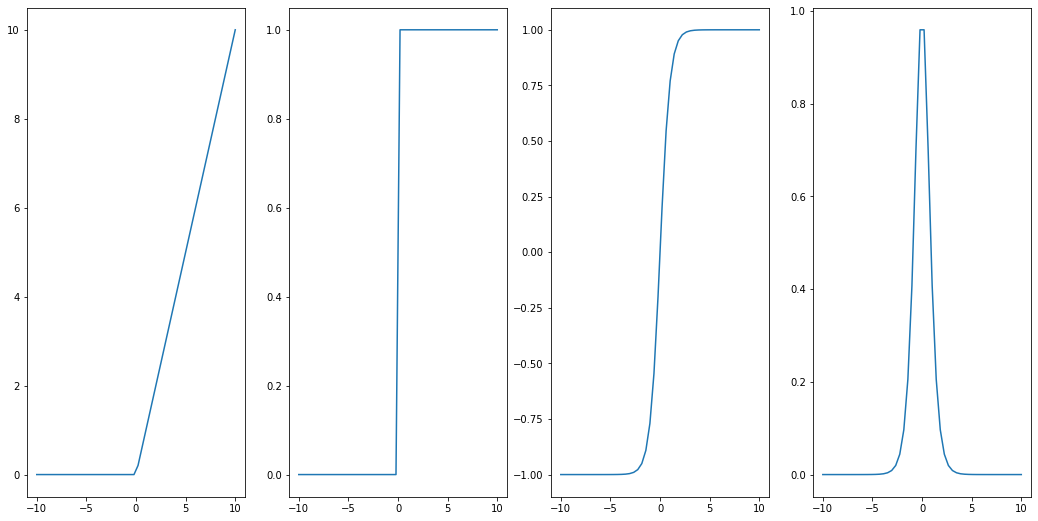

In [16]:
# let's visualize the activation functions and their first order derivatives

x = np.linspace(-10, 10)


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18,9))
ax1.plot(x, ReLU(x))
ax2.plot(x, dReLU(x))
ax3.plot(x, tanh(x))
ax4.plot(x, dtanh(x))

# Loss Function

As a loss function we simply define a mean squared error. The "main goal" of our network is to minimize this loss. Therefore we simply compare our models prediction with the true values (and square it). If we are given with a classification task a very common loss function is the crossentropy

In [17]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size


# cross entropy as introduced in the lecture could e.g. be calculated as follows:
def cross_entropy(y_true, y_pred):
    n = len(y_true)
    return -1/n * sum(y_true*np.log(y_pred) + (1 - y_true) * np.log(1-y_pred))




In [18]:
np.random.randn(3, 3) * 0.05

array([[-0.01118169, -0.06288205, -0.08926335],
       [ 0.03037961,  0.02284996, -0.12904992],
       [-0.00868009,  0.05278329,  0.0420935 ]])

Now we define the network structure itself. 

First, we will initiliaze the weights and the biases. As the shape/size of these initializations is always dependent on the shape of the input, we initiliaze them accordingly.
In the lecture we initiliazed the weights as values between 0.1 and 0.9. Here we choose to randomly draw values from a somehwat "truncated" normal distribution. A 3x3 weight matrix as initiliazed in the lecture could thus look like this:

$$
\left(\begin{array}{ccc} 
0.02641374 &  0.01506347 &  0.10466635\\
-0.02618074 & -0.00652272 &  0.06866112\\
0.00623723 &  0.02650697 & -0.02427058
\end{array}\right)
$$ 
       
Second, we define the Forward pass which is, as the name suggest, the models pass of the inputs into the "forward direction". As you know, the output of a previous layer is the input of the next layer, which basically means that e.g. the output of the first layer becomes the input of the second layer.

We simply multiply the weights times the input, plus the bias, which translates to: np.dot(inputs, weights) + bias

$$
  \begin{pmatrix}
    h_{1}^{(1)} \\[0.3em]
    h_{2}^{(1)} \\[0.3em]
    h_{3}^{(1)}
  \end{pmatrix}
  =
  \begin{pmatrix}
    w_{1,1} & w_{1,2} &  w_{1,3} \\
    w_{2,1} & w_{2,2} &  w_{2,3} \\
    w_{3,1} & w_{3,2} &  w_{3,3}
  \end{pmatrix}
  \begin{pmatrix}
    i_{1}^{(0)} \\[0.3em]
    i_{2}^{(0)} \\[0.3em]
    i_{3}^{(0)}
  \end{pmatrix}
  +
  \begin{pmatrix}
    b_{1}^{(0)} \\[0.3em]
    b_{2}^{(0)} \\[0.3em]
    b_{3}^{(0)}
  \end{pmatrix}

$$

As a first step we did not implement any activation functions. However, the results above will change if we use these in the form as presented in the lecture.

Let's go ahead and try out the values introduced in the lecture in the forward pass and use ReLU as an activation function:




In [19]:
# Lets first define the same weight matrix, the same values and the same bias

example_weights =  np.arange(0.1, 1, 0.1).reshape(3,3)
example_values = np.array([[0.21, 0.32, 0.43]]).reshape(3, 1)
example_bias = np.array([[0.1, 0.1, 0.1]]).reshape(3, 1)

example_y_true = np.array([[0.0, 0.0, 1.0]]).reshape(3, 1)

# lets compute a simple forward pass by multiplying the weights and the input values and adding the bias
example_forward = np.dot(example_weights, example_values) + example_bias
example_forward

array([[0.314],
       [0.602],
       [0.89 ]])

Now we use a different activation function than in the lecture and use a ReLU activation function, thus delivering different results

In [20]:
act_example_forward = ReLU(example_forward)
act_example_forward

array([[0.314],
       [0.602],
       [0.89 ]])

If we now compute the loss (here a different than used in the lecture), we get a loss of:

In [21]:
mse(example_y_true, act_example_forward)

0.15769999999999998

In [22]:
#if using crossentropy we would get
cross_entropy(example_y_true, act_example_forward)

# If you compare these values to the one from the lecture you already can see an impact from the activation function

array([0.47157158])

To build the model and create it as flexible as possible we create multiple classes which we can later use.

Firstly we need to initiliaze the weights and the biases. We do that as described above.

Secondly we write the functions for the described forward pass, without any form or activation. 
The most important part is the backward pass. The main idea is, that we adjust a parameter by subtracting the derivative of the error with respect to the parameter itself. The derivatives can easily be calculated with tha chain rule and our previously defined helper functions. 

In [23]:
class DenseLayer:
    def __init__(self, n_inputs, n_neurons):
        # first we initilaize the weights with a random draw from a normal distribution
        # To circumvent drawing to large weights, we simply multiply all drawn values with 0.1
        # Another approach could be to simply subtract e.g. 0.5 from every drawn value
        # Often the weights are initilized with a truncated normal distribution, where all values larger than
        # (I think) 2 standard deviations are neglected and so to speak drawn again until a value in the given range is found
        # Additionally we initilize the bias as 0's. but could also initilaize them as values close to zero, e.g. with
        # np.random.rand(1, n_neurons) - 0.5
        self.weights = np.random.randn(n_inputs, n_neurons) * 0.05
        self.bias = np.zeros((1, n_neurons))

    def feed_forward(self, inputs):
        # Here you see the same forward pass as described above
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.bias
        return self.output

    def backward_propagation(self, output_error, learning_rate):


        # the input error can be calculated by multiplying the derivative of the error
        # with respect to y with the transposed weights. 
        input_error = np.dot(output_error, self.weights.T)

        # lets comput dE/dW which is (see chainrule) equal to the
        # transposed inputs multiplied by the derivative of the output error
        # with respect to y
        weights_error = np.dot(self.inputs.T, output_error)

        # Now lets update the parameter
        # we do that by changing the given parameters (weights and bias) 
        # with a given elarning rate and the computed "errors"
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error
    






Now we implement that same process for an activation layer.

Note, that we pass a learning rate to the backpropagation although there is no learning rate involved. We do that simply for convenience,
that we can later easily switch between passing the backward_propagation function from either type of Layer.

Here we do not initiliaze any weights or biases (as they are already initiliazed). However, we define the activation function and the derivative of the acitvation function (see helper fucntions from above). A forward pass is thus just "passing" the inputs through that activation function. In terms of the complete model, we first pass the input data through a fully connected layer (DenseLayer) and pass that output through the Activaion Layer.

The backward propagation simply returns the activation functions derivative multiplied by the output error, as we want to basically calculate the error derivative with respect to the input data. Again, using the chain rule that can be expressed as:

$$
\frac{\partial{E}}{\partial{Y}} \odot f'(x)

$$

In [24]:
class ActivationLayer:
    def __init__(self, activation, deriv_activation):
        self.activation = activation
        self.deriv_activation = deriv_activation

    def feed_forward(self, inputs):
        self.inputs = inputs
        self.output = self.activation(self.inputs)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.deriv_activation(self.inputs) * output_error

Now we start combining everything together to a complete network. Just have the overall process of forward and backward passes in mind.

First, we initiliaze the loss function and the loss derivative. Additionally we implement the layers simply as a list, where we can add layers to.

Second, we define exactly that adding function that simply appends layers to that list

Third, we define a predict function such that we can predict new data with our model. The prediction is simply to feed unseen and new data through the model.

Last, we write the "fit" function that implements all defined functions in the correct order.



In [25]:
class Network:
    def __init__(self, loss, deriv_loss):
        # first lets create an empty list for the layers
        self.layers = []

        # initiliaze the loss and the derivative as None values
        self.loss = loss
        self.deriv_loss = deriv_loss

    # define an add function such that we can add/append layers to our network
    def add(self, layer):
        self.layers.append(layer)


    # define a prediction function
    def predict(self, inputs):

        N = len(inputs)
        result = []
        for i in range(N):
            output =  inputs[i]
            for layer in self.layers:
                output = layer.feed_forward(output)
            result.append(output[0][0])

        return result

    # now the fitting function
    def fit(self, x_train, y_train, epochs=10, learning_rate=0.1):
        """[summary]

        Args:
            x_train ([type]): training input data
            y_train ([type]): y values (data to predict)
            epochs (int, optional): Number of epochs we are training. Defaults to 10.
            learning_rate (float, optional): learning rate with which the parameters are adapted. Defaults to 0.1.
        """


        N = len(x_train)

        # first we iterate through the training process for the number of epochs
        for i in range(epochs):
               
            # second we create a loss variable which we initliaze with zero in every epoch
            loss_ = 0

            # feed forward (forward propagation)
            for j in range(N):
                # first we define every single value from our training data 
                output = x_train[j]

                # second we pass that value through every layer in the feed forward pass.
                # That means that in the dense layers we calculate weights*input+ bias
                # and in the activation layer we "activate" that output
                # That is the reason why we call that variable "output" in every pass
                # such that we do not have to define everything seperately.
                for layer in self.layers:
                    output = layer.feed_forward(output)
                    
                # we calculate the loss by "comparing" the output after each forward pass
                # and the true value
                loss_ += self.loss(y_train[j], output)

                # and here we calculate the error, that is the derivative of the loss with respect to y
                error = self.deriv_loss(y_train[j], output)

                # in the backward propagation we now pass that error (deriv of loss) to the backward propagation of the functions
                # Note how we specified the learning rate as parameter for every layer, even when its not called.
                # That is done, such that we do not have to backpropagate through different layers with different functions
                # here the weights are adapted
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)
                    
            # as we summed up the loss we need to divide by N
            loss_ /= N

            # print every 50'th epoch and the loss to see if convergence
            if i % 50 == 0:
                print('epoch %d/%d   loss=%f' % (i+1, epochs, loss_))


In [26]:
# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])


# network
net = Network(mse, mse_derivative)
net.add(DenseLayer(2, 5))
net.add(ActivationLayer(ReLU, dReLU))
net.add(DenseLayer(5, 1))


# train
net.fit(x_train, y_train, epochs=300, learning_rate=0.1)

# test
predict_train = net.predict(x_train)
print(np.round(predict_train, 3))

epoch 1/300   loss=0.441220
epoch 51/300   loss=0.020029
epoch 101/300   loss=0.000000
epoch 151/300   loss=0.000000
epoch 201/300   loss=0.000000
epoch 251/300   loss=0.000000
[0. 1. 1. 0.]
